In [1]:
!pip install -U tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompat

In [2]:
# Common
import os
import keras
import numpy as np
from tqdm import tqdm
from PIL import Image

# Google
from google.cloud import storage
from google.colab import drive

# Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, GlobalAvgPool2D

# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Transfer Learning Models
from tensorflow.keras.applications import ResNet152V2, InceptionV3

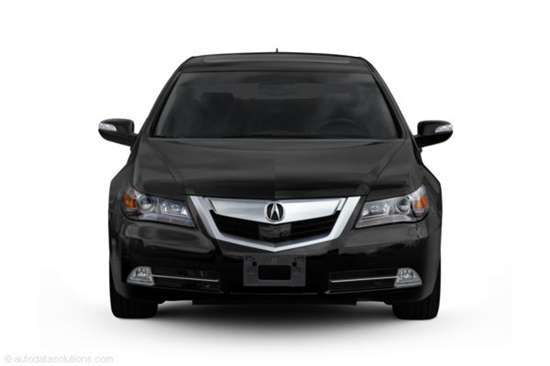

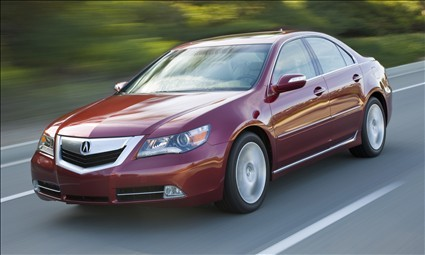

In [3]:
# Connect to GCS Bucket
RAW_DATA_BUCKET_NAME="mini-215-multiclass-car-bucket"
client = storage.Client.from_service_account_json('/content/data-service-account-model.json')
bucket = client.get_bucket(RAW_DATA_BUCKET_NAME)
blob = bucket.blob('car_folder/train/Acura RL Sedan 2012/00670.jpg')
blob_test = bucket.blob('car_folder/test/Acura RL Sedan 2012/00249.jpg')

# Test downloading one image
file_name = 'car.jpg'
file_test_name = 'car_test.jpg'

blob.download_to_filename(file_name)
image = Image.open(file_name)
display(image)

blob_test.download_to_filename(file_test_name)
image_valid = Image.open(file_test_name)
display(image_valid)

In [4]:
from google.cloud import storage
import os

def download_images_from_specific_folder(bucket_name, target_folder, secrets_path):
    """
    Downloads all images from a specific folder in a GCS bucket.

    Args:
        bucket_name (str): The name of the GCS bucket.
        target_folder (str): The folder within the bucket to download images from.
    """
    storage_client = storage.Client.from_service_account_json(secrets_path)
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=target_folder)

    for blob in blobs:
        if blob.name.endswith('/'):
            continue
        parts = blob.name.split('/')
        folder_name = '/'.join(parts[:-1])

        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        blob.download_to_filename(os.path.join(folder_name, parts[-1]))
        print(f"Downloaded {blob.name} to {os.path.join(folder_name, parts[-1])}")

In [5]:
bucket_name = 'mini-215-multiclass-car-bucket'
target_folder = 'car_preprocessed_folder'
secrets_path = '/content/data-service-account-model.json'
download_images_from_specific_folder(bucket_name, target_folder, secrets_path)

Downloaded car_preprocessed_folder/all_images/00128.jpg to car_preprocessed_folder/all_images/00128.jpg
Downloaded car_preprocessed_folder/all_images/00128_bright.jpg to car_preprocessed_folder/all_images/00128_bright.jpg
Downloaded car_preprocessed_folder/all_images/00128_dark.jpg to car_preprocessed_folder/all_images/00128_dark.jpg
Downloaded car_preprocessed_folder/all_images/00128_flip.jpg to car_preprocessed_folder/all_images/00128_flip.jpg
Downloaded car_preprocessed_folder/all_images/00128_rot-15.jpg to car_preprocessed_folder/all_images/00128_rot-15.jpg
Downloaded car_preprocessed_folder/all_images/00128_rot15.jpg to car_preprocessed_folder/all_images/00128_rot15.jpg
Downloaded car_preprocessed_folder/all_images/00130.jpg to car_preprocessed_folder/all_images/00130.jpg
Downloaded car_preprocessed_folder/all_images/00130_bright.jpg to car_preprocessed_folder/all_images/00130_bright.jpg
Downloaded car_preprocessed_folder/all_images/00130_dark.jpg to car_preprocessed_folder/all_im

In [6]:
import os
import shutil
import pandas as pd


all_images_path = '/content/car_preprocessed_folder/all_images/'
csv_path = '/content/car_preprocessed_folder/class_label.csv'
organized_data_path = '/content/organized'


df = pd.read_csv(csv_path)

for label in df['label_encoded'].unique():
    label_dir = os.path.join(organized_data_path, str(label))
    os.makedirs(label_dir, exist_ok=True)

for _, row in df.iterrows():
    image_name = row['image_name']
    label = row['label_encoded']
    source_path = os.path.join(all_images_path, image_name)
    dest_path = os.path.join(organized_data_path, str(label), image_name)

    if os.path.exists(source_path):
        shutil.move(source_path, dest_path)
    else:
        print(f"Warning: {image_name} not found in {all_images_path}")

print("Images have been organized into subdirectories by label.")

Images have been organized into subdirectories by label.


In [7]:
PATH = '/content/organized'
CLASS_COUNT = 196

# Initialize Generator
gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.8,
)


# Load data
train_ds = gen.flow_from_directory(
    PATH,
    target_size=(224,224),
    class_mode='binary',
    batch_size=16,
    shuffle=True,
    subset='training'
)

val_ds = gen.flow_from_directory(
    PATH,
    target_size=(224,224),
    class_mode='binary',
    batch_size=16,
    shuffle=True,
    subset='validation',
)

Found 10 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


In [8]:
# Model Name
name1 = "CarNetV1"

# Pretrained Model
base_model = ResNet152V2(include_top=False, input_shape=(224,224,3), weights='imagenet')
base_model.trainable = False # Freeze the Weights

# Model
CarNetV1 = Sequential([
    base_model,
    GlobalAvgPool2D(),
    Dense(224, activation='leaky_relu'),
    Dense(CLASS_COUNT, activation='softmax')
], name=name1)

CarNetV1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

# Train
CarNetV1.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - accuracy: 0.0000e+00 - loss: 6.3605 - val_accuracy: 0.2632 - val_loss: 3.2108
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 1.0000 - loss: 2.1331 - val_accuracy: 0.6316 - val_loss: 1.4853
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 1.0000 - loss: 0.1832 - val_accuracy: 0.6842 - val_loss: 1.5830
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.6842 - val_loss: 1.9992
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.6842 - val_loss: 2.4069
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 1.0000 - loss: 2.8279e-04 - val_accuracy: 0.6842 - val_loss: 2.7809
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 1.0000 - loss: 1.1172e-04 - val_accuracy: 0.6579 - val_loss: 3.1228
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
